# Understanding the Cloud through data analysis
This project is accesible at: https://github.com/rita-imdea/ripe-userguide 
The supplementary PDF file can be found at https://github.com/rita-imdea/ripe-userguide/blob/main/latency2guide.pdf

In this notebook, we are going to see how to retrieve measurements fron RIPE Atlas and also how to parse measurements from JSON files (which have been pre-downloaded from RIPE Atlas). 
We recommend the reader to first take a look at the PDF document that contains the guide for the whole course. 

------------------------------

This notebook is divided in 2 parts. 

    
#### A) PARSING YOUR MEASUREMENTS
    We will explain how to clean and pre-process the data, which are *essential* steps to obtain good results.
    
#### B) ANALYZING YOUR MEASUREMENTS 
    The statistical analysis of the data
    
------------------------------

This project makes use of data from RIPE Atlas, a measurement platform that contains public measurements. These measurements consists of the parameters and statististics of all the messages sent from some source devices, named "probes", towards some IP addresses or urls, named "destinations". These data allow us to understand how Internet works and how time and space impact on latency. 

Let's start!

------------------------------
------------------------------

First of all, we need to install some python packages that are required to contact with the RIPE Atlas server and to parse JSON files. Some other packages will be imported later on when they are needed. Make sure that you have installed the packages (see the guide that is accessible from the link on top of this file)

In [1]:
import requests # to create http requests from Python
import json     # Library to write and ready JSON files in PYthon

Next, we check how to pass from a retrieved JSON file to a meaningful format in Python to work with the data.


### A) PARSING YOUR MEASUREMENTS

Wwe are going to get the data from the JSON files, which are already present in the course directory; you can also obtain other measurements from https://atlas.ripe.net/measurements/, as explained in Section III.B of latency2guide.pdf

The next steps are:

1. Initially, we parse the JSON files and store the data in a Python structure 
2. We clean the data

-----------------------------------------

!!!!!!!!!!!!!!!! To complete

3. Finally you can plot the probability distribution to see how the data is spread 

First, we set the IDs of the measurements we are interested in. 
In this case, the IDs provided below refer to the measurements taken for this course. 

In [2]:
#measurement_ids = ["48819905", "48819907", "48819909"] # example of measurement ID -- PING MEASUREMENTS
#measurement_ids = ["48819906", "48819908", "48819910"] # example of measurement ID -- TRACEROUTE MEASUREMENTS
measurement_ids = ["48819905",  "48819907",  "48819909"] # example of measurement ID


### a) Reading JSON files in Python

Next, we use the Python library "json", which allows us to ready and write JSON files with Python.
Furthermore, we use two of the most used packages for data processing in PYthon: Pandas and Numpy. 

1. Pandas is a Python library that provides a data structure called a DataFrame (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), which is a structure that facilitates data processing and manipulation. We can visualize it as a matrix that contains data of different format. We shall use it to parse our data because it provides a number of useful functions for manipulation and visualization of data.

2. Numpy is a Python library that facilitates mathematical operations, in particular for arrays and matrices. 

3. We also import datetime to work with different time formats.

In [3]:
# We first import the necessary libraries 
import pandas as pd
import numpy  as np
from datetime import datetime

For each one of the measurements, we read the JSON file and store it in a pandas DataFrame (df) structure.

Then, we create a list of DataFrames (df) with all the measurements. 

In [4]:
# Loop through the measurement IDs experiment files and create a DataFrame for each

dfs = [] # creating an empty vector for DataFrame elements

for measurement_id in measurement_ids: # For each of the measurements that we are considering:
    
    # Read the JSON data from the file
    with open(f"RIPE-Atlas-measurement-{measurement_id}.json", "r") as f:
        json_data = json.load(f)
    
    # Normalize the JSON data into a pandas DataFrame
    df = pd.json_normalize(json_data)
    
    # Append the DataFrame to the list of DataFrames
    dfs.append(df)


We would like to have all the DataFrames together to analyze all the measurements at the same time. Thus, we concatenate the list of dataframes.

In [5]:
# Concatenate all the DataFrames into a single one
result_df = pd.concat(dfs, ignore_index=True)

We can visualize the current data structure thanks to the pandas function "head", which prints the first 5 rows of the DataFrame with the value of all the columns.

In [6]:
# Print the resulting DataFrame
result_df.head()

,fw,mver,lts,dst_name,af,dst_addr,src_addr,proto,ttl,size,...,avg,msm_id,prb_id,timestamp,msm_name,from,type,group_id,step,stored_timestamp
0,5040,2.4.1,14,52.46.72.50,4,52.46.72.50,10.18.246.209,ICMP,234.0,64,...,14.612530,48819905,1003454,1673864005,Ping,51.15.99.8,ping,48819905,300,1673864050
1,5040,2.4.1,20,52.46.72.50,4,52.46.72.50,10.109.0.30,ICMP,233.0,64,...,24.125096,48819905,1003747,1673864003,Ping,45.137.88.145,ping,48819905,300,1673864114
2,5080,2.6.2,96,52.46.72.50,4,52.46.72.50,192.168.250.65,ICMP,233.0,64,...,22.542065,48819905,20757,1673863991,Ping,82.116.160.225,ping,48819905,300,1673864089
3,5080,2.6.2,12,52.46.72.50,4,52.46.72.50,192.168.1.38,ICMP,234.0,64,...,26.183208,48819905,53229,1673864019,Ping,83.54.157.101,ping,48819905,300,1673864090
4,5080,2.6.2,33,52.46.72.50,4,52.46.72.50,192.168.0.101,ICMP,232.0,64,...,171.458986,48819905,51381,1673864074,Ping,102.34.0.4,ping,48819905,300,1673864205


### b) Data cleaning and pre-processing

The following step is to clean the data collection. 

For that, we should first know that the RIPE Atlas measurements may include negative values for latency (-1.0), which represent samples for which it was not possible to store the value (Due to, for example, timeouts in the network protocols). 


To avoid that these values impact the later analysis, we remove those samples. We first transform the negative values into Not-a-Number values (NaN), and we make use of the function "dropna" from Pandas library to remove those samples.  

In [7]:
## Cleaning the data 

original_data_size = result_df.shape # saving the number of rows and columns for later

# Change the negative values to NaN
result_df['avg'].replace(-1.0, np.nan, inplace=True)

# Remove NaN values 
result_df = result_df.dropna(how='any',axis=0) 

print(f"Original size: {original_data_size} /// Processed size = {result_df.shape}")


Original size: (17265, 26) /// Processed size = (17119, 26)


We can easily check the percentage of "broken" samples that there were:

In [8]:


print(f"We have {original_data_size[0]-result_df.shape[0]} bad samples {original_data_size[0]} among total samples.")

print(f"That means that {(original_data_size[0]-result_df.shape[0])/original_data_size[0]*100:.2f}% of the samples have been discarded")


We have 146 bad samples 17265 among total samples.
That means that 0.85% of the samples have been discarded


We further pre-process the data to facilitate the plotting, visualization and readability of the data.

For that, we change the probe ID with an acronym that represents the country where the probe is located, plus an index in case there are several probes in the same country. 

In [9]:
# Renaming the probe_id column for easy plotting 
nprb_id = []

for value in result_df["prb_id"]:
    if value == 1004991:
        nprb_id.append('es1')
    if value == 53229:
        nprb_id.append('es2')
    if value == 1004997:
        nprb_id.append("pt1")
    if value == 1004102:
        nprb_id.append("pt2")
    if value == 20757:
        nprb_id.append("es3")
    if value == 1003454:
        nprb_id.append("nl1")
    if value == 1003158:
        nprb_id.append("nl2")
    if value == 1003747:
        nprb_id.append("nl3")
    if value == 1004200:
        nprb_id.append("es4")
    if value == 51381:
        nprb_id.append("ug1")
    if value == 54470:
        nprb_id.append("us1")
    if value == 1002914:
        nprb_id.append("us2")
        
# Saving the new IDs in the column "nprb_id"
result_df["nprb_id"] = nprb_id


Now, we edit the format in which the time is saved. By default, the time units provided by RIPE Atlas are UNIX timestamps, i.e., the number of seconds passed since 1st January 1970 at 00:00h.

In [10]:
## Changing the time column from epoch to date time format for time series processing

new_timestamp = [] # initializing the new array

# populating the new array
for i in result_df['timestamp']:
    my_datetime = datetime.fromtimestamp(i) # transforming the timestamp in standard time
    new_timestamp.append(my_datetime) # adding the value to the array

# Saving the new time format in the column "new_time"
result_df['new_time'] = new_timestamp


The last pre-processing is to save the code of the country in which the probe is located. 

In [11]:
# itializing the country code array
country_name = []

for value in result_df["nprb_id"]:
    if (value == 'es1') or (value == 'es2') or(value == 'es3') or( value == 'es4'):
        country_name.append('Spain')
    if(value == 'nl1') or (value == 'nl2')or (value == 'nl3'):
        country_name.append('Netherlands')
    if(value == 'pt1') or (value == 'pt2'):
        country_name.append('Portugal')
    if(value == 'us1') or (value == 'us2'):
        country_name.append('USA')
    if(value == 'ug1'):
        country_name.append('Uganda')

# Saving the new country code in the column "country_name"
result_df['country_name'] = country_name


We can visualize if the new additions are correct by calling again the method df.head(). You will see that the last three columns coincide with the content that we have just added.

In [12]:
result_df.head()

,fw,mver,lts,dst_name,af,dst_addr,src_addr,proto,ttl,size,...,timestamp,msm_name,from,type,group_id,step,stored_timestamp,nprb_id,new_time,country_name
0,5040,2.4.1,14,52.46.72.50,4,52.46.72.50,10.18.246.209,ICMP,234.0,64,...,1673864005,Ping,51.15.99.8,ping,48819905,300,1673864050,nl1,2023-01-16 11:13:25,Netherlands
1,5040,2.4.1,20,52.46.72.50,4,52.46.72.50,10.109.0.30,ICMP,233.0,64,...,1673864003,Ping,45.137.88.145,ping,48819905,300,1673864114,nl3,2023-01-16 11:13:23,Netherlands
2,5080,2.6.2,96,52.46.72.50,4,52.46.72.50,192.168.250.65,ICMP,233.0,64,...,1673863991,Ping,82.116.160.225,ping,48819905,300,1673864089,es3,2023-01-16 11:13:11,Spain
3,5080,2.6.2,12,52.46.72.50,4,52.46.72.50,192.168.1.38,ICMP,234.0,64,...,1673864019,Ping,83.54.157.101,ping,48819905,300,1673864090,es2,2023-01-16 11:13:39,Spain
4,5080,2.6.2,33,52.46.72.50,4,52.46.72.50,192.168.0.101,ICMP,232.0,64,...,1673864074,Ping,102.34.0.4,ping,48819905,300,1673864205,ug1,2023-01-16 11:14:34,Uganda


------------------------------

We have already cleaned and structured our data. Now, it's time to analyze and extract valuable information from it. 

------------------------------
------------------------------
------------------------------

### B) ANALYZING YOUR MEASUREMENTS 

We split this

1. Check how latency varies over time, how mean and standard deviation vary over distance or any other interesting scenarios you can come up with 
2. Finally you can do some predictions based using established mathematical models or machine learning models and see what gives you best results.  

### a) Understanding the data
The first step is to take a look at the data we have and try to obtain insights that can help us with the later analysis.

Let us first check what is the probability distribution of the latency for the whole dataset.

For that, we plot the discrete PDF based on the histogram of the data.

Text(0.5, 0, 'Latency (ms)')

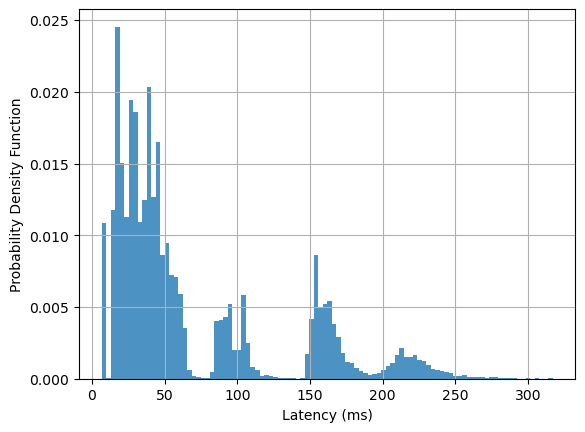

In [13]:
# Computing the discrete PDF from the histogram

axx = result_df['avg'].hist(density=True, bins=100, alpha = 0.8) 
# bins = Number of points in the histogram.
# alpha = a parameter for color transparency

# We can add information into the graph
axx.set_ylabel("Probability Density Function")
axx.set_xlabel("Latency (ms)")

We realize that the shape is quite curious, with several peaks, looking like a decreasing wave. 

**What can be the reason?**<br>

**Please, take a moment to think about it and comment in group what you think about the graph above**<br> 

Don't continue further down until you took your time to talk about it.

---------------------------------------------------------------

**... 
<br><br>
...
<br><br>
...
<br><br>
...
<br><br>
...
<br><br>
...
<br><br>**

Have you already thought about it? Let us see if we can dive a bit deeper into the data.

Let us consider now some of the information we have to try to get more insights.<br>

First, let us check what is the PDF for the data originated in each probe, separately.


Text(0.5, 0, 'Latency (ms)')

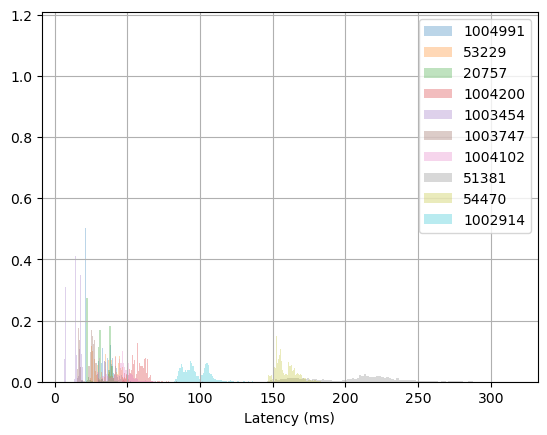

In [14]:
## checking PDF for each of the probes

# First, we recover the array of probe IDs. These IDs are identifiers used for RIPE Atlas, the measurements platform. 
probes = [1004991,53229,20757,1004200,1003454,1003747,1004102,51381,54470,1002914]
         
# We extract the data corresponding to each probe, and plot it separately but in the same plot
for probe in probes:
    df_cdf = result_df[(result_df['prb_id'] == probe)]  # Get the data that corresponds to one probe
    axx = df_cdf['avg'].hist(density=True, bins=100, alpha = 0.3) # Draw the histogram

# We add the probe IDs as legend
axx.legend(probes)
axx.set_xlabel("Latency (ms)")

What can we observe?<br>

**Any ideas??**<br>


Take a moment to propose ideas before continuing. 
<br>

---------------------------------------------------------------

**... 
<br><br>
...
<br><br>
...
<br><br>
...
<br><br>
...
<br><br>
...
<br><br>**

(...)


 
<br><br>

<br><br>

<br><br>

<br><br>

<br><br>

<br><br>


So, it seems that there are some probes that are easily differentiable from the rest of the probes.
But that plot shows us little information about **why**.

Also, the probe IDs is not a very meaningful value. We can use the attibute that we have previously added identifying probes with the country where they are located. Let us know plot the same graph with the new ID.

Text(0.5, 0, 'Latency (ms)')

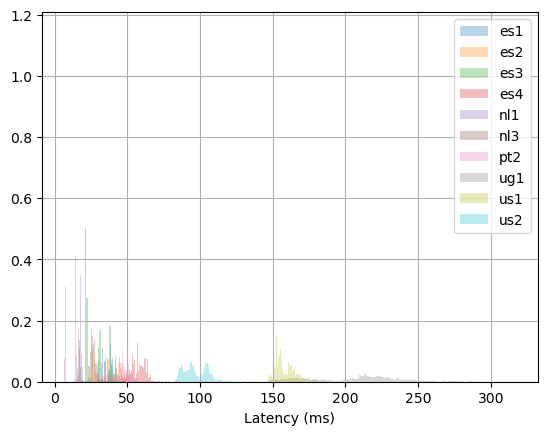

In [15]:
## checking PDF for each of the probes

# First, we recover the array of probe IDs
probes = ['es1','es2','es3','es4','nl1','nl3','pt2','ug1','us1','us2']
         
# We extract the data corresponding to each probe, and plot it separately but in the same plot
for probe in probes:
    df_cdf = result_df[(result_df['nprb_id'] == probe)] # Get the data that corresponds to one probe
    axx = df_cdf['avg'].hist(density=True, bins=100, alpha = 0.3) # Draw the histogram

# We add the probe IDs as legend
axx.legend(probes)
axx.set_xlabel("Latency (ms)")

It is clear that the country of location have an important impact. In order to better verify it, we can show the results aggregated by country. Let us see what is the outcome of this visualization.

Text(0.5, 0, 'Latency (ms)')

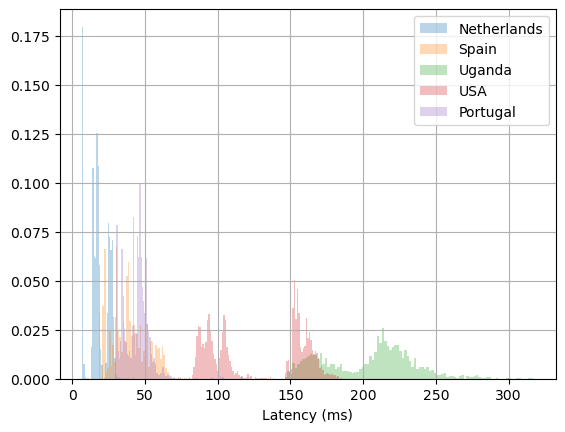

In [16]:
## Obtaining PDF per country

# Retrieving list of countries from the data
countries = result_df['country_name'].unique()

for country in countries:
    df_pdf = result_df[(result_df['country_name'] == country)] # Get the data that corresponds to one country
    axx = df_pdf['avg'].hist(density=True, bins=100, alpha = 0.3) # Draw the histogram 

axx.legend(countries)
axx.set_xlabel("Latency (ms)")

Now we see more clearly that **location matters** for latency and internet. This, which is expected by all of us, it is not necessary true if we do not corroborate it with data. 

More in detail, Portugal and Spain obtain the same performance, as they are next to each other and the servers are located in further places such us Netherlads, U.S., and other countries. 

This results showcases the fact that, if we want to know whether some edge-cutting application can be deployed in a certain place, we need to first make sure that the network has a sufficiently good performance to actually allow for the service to work.

In the following, we advance a bit deeper on the characterization of the data. 


-----------------------------------

One crucial value to understand the latency values is to know where each of the probes and destinations are located. 

For that, we now obtain the coordinates of all the devices (sources and destinations) participating in the experiment, and we include it in the DataFrame object. 

In [17]:
## Obtaining geographical information of the probes 

# Import the package needed to format the metadata of RIPE's probes.
from ripe.atlas.cousteau import Probe 

#Getting all the ripe atlas probes
probe_id_list = result_df['prb_id'].unique()
probe_nid_list = result_df['nprb_id'].unique()

# Collect the source probe latitude/longitude information from ripe atlas 
probe_coordinates = []
probe_country = []

for id_i in probe_id_list: # for each one of the probes:
    probe = Probe(id=id_i) # Obtains all metadata of probe id_i
    #print(probe.geometry) #probe.geometry is a GeoJSON https://en.wikipedia.org/wiki/GeoJSON
    probe_coordinates.append(probe.geometry['coordinates']) # saving the coordinates to the list of coordinates
    probe_country.append(probe.country_code)



We now have a list with the information of coordinates for each of the probes. Next, we tranform it into latitude and longitude, and we add the country in which they are located. 

In [18]:
longitude = []
latitude = []

for i in probe_coordinates:
    longitude.append(i[0])
    latitude.append(i[1])

# create a probe metadata dataframe
srcprobes_df = pd.DataFrame({'prb_id': probe_nid_list,'longitude': longitude, 'latitude': latitude,'probe_country': probe_country})
srcprobes_df

,prb_id,longitude,latitude,probe_country
0,nl1,4.8995,52.3695,NL
1,nl3,4.3695,51.8505,NL
2,es3,-1.9805,43.2905,ES
3,es2,-5.5915,42.6115,ES
4,ug1,32.5615,0.2575,UG
5,us1,-122.0795,37.3875,US
6,us2,-73.9625,40.6495,US
7,pt2,-8.6225,41.2285,PT
8,es4,-15.5025,28.0275,ES
9,es1,-0.9085,41.5975,ES


We have done this for the probes (source nodes). We can repeat the procedure for the destination addresses.

In [19]:
## Obtaining geographical information of the destinations 

#Getting all the destination ip addresses
dest_ip_list = result_df['dst_addr'].unique()

# Create empty lists to store the data
server_ip = []
latitudes = []
longitudes = []

# Query the "ipinfo.io" API for geolocation information
for ip in dest_ip_list:
    response = requests.get(f'https://ipinfo.io/{ip}/json')
    if response.status_code == 200:
        data = response.json()
        latitude, longitude = data.get('loc', '').split(',')
        server_ip.append(ip)
        latitudes.append(latitude)
        longitudes.append(longitude)

# Create a dataframe with the geophraphical information of the destinatiuon addresses. Remember that this infomation is approximate for privacy reasons
a_server_df = pd.DataFrame({ 'Server_ip': server_ip,'latitude': latitudes, 'longitude': longitudes})
a_server_df

,Server_ip,latitude,longitude
0,52.46.72.50,48.8534,2.3488
1,54.239.55.167,50.1155,8.6842
2,67.220.226.67,53.3331,-6.2489


We have now all the information regarding the location of the addresses participating in the experiment. Thus, we can now calculate the distance between sources and destinations. 

In [29]:
## Obtaining the distance between nodes. 

# We first define the function that computes the Euclidean distance between two points
distance_data = []
def euclidean_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    return np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)

# Create an empty dataframe to store distance information
distance_df = pd.DataFrame(columns=['prb_id', 'ip_address', 'distance'])

# Calculate Euclidean distances between all probes and destination addresses
for index_probe, row_probe in srcprobes_df.iterrows():
    for index_dst, row_dst in a_server_df.iterrows():
        distance = euclidean_distance(float(row_probe['latitude']), float(row_probe['longitude']), float(row_dst['latitude']), float(row_dst['longitude']))
        distance_data.append({
            'nprb_id': row_probe['prb_id'],
            'dst_addr': row_dst['Server_ip'],
            'distance': distance})
        
# Create a DataFrame from the list of distance information
distance_df = pd.DataFrame(distance_data)


We can show the distance between all probes and destinations as follows: 

In [30]:
distance_df

,nprb_id,dst_addr,distance
0,nl1,52.46.72.50,4.343850
1,nl1,54.239.55.167,4.405051
2,nl1,67.220.226.67,11.189966
3,nl3,52.46.72.50,3.614670
4,nl3,54.239.55.167,4.650469
5,nl3,67.220.226.67,10.721405
6,es3,52.46.72.50,7.049021
7,es3,54.239.55.167,12.661613
8,es3,67.220.226.67,10.912060
9,es2,52.46.72.50,10.099984


We now add this information to our general DataFrame.

In [33]:
# Adding the distance data to the result_df.
# For that, for each of the points that have the same ['nprb_id', 'dst_addr'] tuple, we add the field of distance between those nodes. 
analysis_df  = pd.merge(result_df,distance_df, left_on=['nprb_id', 'dst_addr'], right_on=['nprb_id', 'dst_addr'], how='inner')


We can visualize the first 5 rows to check that the value is there. 

In [34]:
analysis_df.head()

,fw,mver,lts,dst_name,af,dst_addr,src_addr,proto,ttl,size,...,msm_name,from,type,group_id,step,stored_timestamp,nprb_id,new_time,country_name,distance
0,5040,2.4.1,14,52.46.72.50,4,52.46.72.50,10.18.246.209,ICMP,234.0,64,...,Ping,51.15.99.8,ping,48819905,300,1673864050,nl1,2023-01-16 11:13:25,Netherlands,4.34385
1,5040,2.4.1,16,52.46.72.50,4,52.46.72.50,10.18.246.209,ICMP,234.0,64,...,Ping,51.15.99.8,ping,48819905,300,1673864355,nl1,2023-01-16 11:18:34,Netherlands,4.34385
2,5040,2.4.1,2,52.46.72.50,4,52.46.72.50,10.18.246.209,ICMP,234.0,64,...,Ping,51.15.99.8,ping,48819905,300,1673864662,nl1,2023-01-16 11:23:26,Netherlands,4.34385
3,5040,2.4.1,14,52.46.72.50,4,52.46.72.50,10.18.246.209,ICMP,234.0,64,...,Ping,51.15.99.8,ping,48819905,300,1673864959,nl1,2023-01-16 11:28:34,Netherlands,4.34385
4,5040,2.4.1,14,52.46.72.50,4,52.46.72.50,10.18.246.209,ICMP,234.0,64,...,Ping,51.15.99.8,ping,48819905,300,1673865254,nl1,2023-01-16 11:33:34,Netherlands,4.34385


------------------------------------

### b) Predicting the data

Now it is turn to see whether we can actually predict the latency on Internet!


In [56]:
# Applying some simple forecasting methods

# Using the naive forecast
result_df = result_df.assign(naive=df['avg'].shift(1))
# Replace NaN at top of value column with 0
result_df['naive'] = result_df['naive'].fillna(method='ffill').fillna(0)

# Testing the prediction accuracy for naive forecast
se = (result_df['avg'] - result_df['naive']) ** 2
mse_naive = se.mean()
mse_naive


6600.607397353303

C:\Users\anton\anaconda3\envs\cloud\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\anton\anaconda3\envs\cloud\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<AxesSubplot:title={'center':'Exponential Smoothing'}>

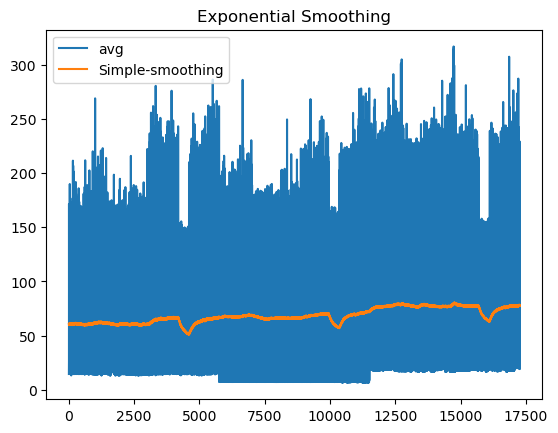

In [57]:
# Exponential smoothing method
from statsmodels.tsa.api import SimpleExpSmoothing
fit1 = SimpleExpSmoothing(result_df['avg']).fit()
result_df['Simple-smoothing'] = SimpleExpSmoothing(result_df['avg']).fit().fittedvalues
result_df[['avg','Simple-smoothing']].plot(title='Exponential Smoothing')

In [58]:
se = (result_df['avg'] - result_df['Simple-smoothing']) ** 2
mse_esm = se.mean()
mse_esm

3718.827871934434

In [23]:
# Using the machine learning models
# First we randomise the dataset and then split it into training and testing sets before applying the models

# Randomising the dataset
import itertools
import random

df2 = analysis_df.copy()

test_indices = []
train_indices = []
        
array1 = df2['nprb_id'].unique()
array2 = df2['dst_addr'].unique()

# Creating all possible pairs
pairs = list(itertools.product(array1, array2))

# Randomly selecting 10 pairs
selected_pairs = random.sample(pairs, 10)

# Removing selected pairs from the original list
for pair in selected_pairs:
    pairs.remove(pair)

# Creating separate lists
selected_list = selected_pairs
remaining_list = pairs

train_dfs = []
for i,k in remaining_list:
    temp_df = df2.loc[(df2['nprb_id'] == i) & (df2['dst_addr'] == k)]
            
    # Append the piece to the selected data
    train_dfs.append(temp_df)

train_df = pd.concat(train_dfs)
        
test_dfs = []
for i,k in selected_list:
    temp_df = df2.loc[(df2['nprb_id'] == i) & (df2['dst_addr'] == k)]
            
    # Append the piece to the selected data
    test_dfs.append(temp_df)

test_df = pd.concat(train_dfs)
        

In [24]:
#normalise the rtt values 
train_df['normalizzed_avg'] = (train_df['avg'] - train_df['avg'].mean()) / train_df['avg'].std()
test_df['normalizzed_avg'] = (test_df['avg'] - test_df['avg'].mean()) / test_df['avg'].std()

# normalize the 'distance' column
test_df['normalizzed_distance'] = (test_df['distance'] - train_df['distance'].mean()) / train_df['distance'].mean()
train_df['normalizzed_distance'] = (train_df['distance'] - train_df['distance'].mean()) / train_df['distance'].mean()

In [25]:
# Select your features and target
X_train = train_df['normalizzed_distance'].values.reshape(-1,1)
y_train = train_df['normalizzed_avg'].values

X_test = test_df['normalizzed_distance'].values.reshape(-1,1)
y_test = test_df['normalizzed_avg'].values

# Import the Machine learning libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Create a Decision Tree Regressor
model = DecisionTreeRegressor()
# Train the model
model.fit(X_train, y_train)
# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the accuracy of the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.025426599955889376


In [26]:
# Viewing the Decision Tree
from sklearn.tree import export_graphviz
import graphviz

tree_dot = export_graphviz(model,feature_names =["distance"],out_file=None,rounded=True, filled=True)

# Visualize the tree using Graphviz
graph = graphviz.Source(tree_dot)
graph

ModuleNotFoundError: No module named 'graphviz'

In [27]:
# LSTM Modelling 
# This code is from this tutorial https://www.youtube.com/watch?v=BSpXCRTOLJA
# please watch the tutorial to understand the code better. It explains how to feed your time series data to the LSTM model
import tensorflow as tf
from tensorflow. keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

In [28]:
from numpy import array
def split_sequence(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
    # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return array(X)


Xtrain_3d = split_sequence(X_train,10)
Xtest_3d = split_sequence(X_test,10)
Xtrain_3d.shape

(11358, 10, 1)

In [29]:
n_features = 1
Xtrain_3d  = Xtrain_3d .reshape((Xtrain_3d.shape[0], Xtrain_3d.shape[1], n_features))
Xtest_3d = Xtest_3d .reshape((Xtest_3d.shape[0], Xtest_3d.shape[1], n_features))
Xtrain_3d[0].shape

(10, 1)

In [30]:
# define model
n_steps = 10 

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(Xtrain_3d, y_train[0:len(Xtrain_3d)], epochs=20, verbose=0)

2023-10-10 10:20:08.994142: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [31]:
y_pred = model.predict(Xtest_3d, verbose=0)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_pred,y_test[0:len(y_pred)])
mse

0.02722562206243606